# Question: Can a car jump over a bridge gap?
### Riya Aggarwal & Odalys Benitez

# Model

You find yourself coming upon London Bridge, trying to make it to your DJ set at the Steel Yard Nightclub within the next half hour. Sneakily, you increase your speed to 30 mph (just 10 mph above the speed limit). SUDDENLY, you hear sirens behind you! You can't afford to lose your gig because DJs barely make a living, so you speed up to 67 mph (a comfortable speed for your BMW series 3 Sedan) and ALAS, the London Bridge starts lifting. Will you make it over? What if you had a different car? Would the angle of the bridge affect you? What if you had gunned it just a little harder or slower? 

### Schematic

!["Schematic"](schematic.png)

### Differential Equation (Drag Equation):

\begin{align}
F_d = \frac{1}{2} \times -\rho \times v \times C_d \times A \\
\end{align}

We used the the drag equation to calculate the backward forces on the car as it sailed through the air toward the other side of the bridge.


### Python Model

In [54]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

# import functions from the matplotlib module
import matplotlib.pyplot as plt
import math as math
from colour import Color

In [55]:
m = UNITS.meter
s = UNITS.second
kg = UNITS.kilogram
degree = UNITS.degree
radian = UNITS.radian;

In [56]:
# The params object with all of our system parameters
params = Params(x = 0 * m, 
                y = 1 * m,
                l = 3.53 * m,
                w = 1.81 * m,
                h = 1.43 * m,
                g = 9.8 * m/s**2,
                mass = 1528.6 * kg,
                rho = 1.2 * kg/m**3,
                C_d = 0.29,
                angle = 45 * degree,
                velocity = 30 * m / s,
                t_end = 1000 * s)

,values
x,0 meter
y,1 meter
l,3.53 meter
w,1.81 meter
h,1.43 meter
g,9.8 meter / second ** 2
mass,1528.6 kilogram
rho,1.2 kilogram / meter ** 3
C_d,0.29
angle,45 degree


In [57]:
def make_system(params):
    """Make a system object.
    
    params: Params object with angle, velocity, x, y,
               diameter, duration, g, mass, rho, and C_d
               
    returns: System object
    """
    unpack(params)
    
    # convert angle to degrees
    theta = np.deg2rad(angle)
    
    # compute x and y components of velocity
    vx, vy = pol2cart(theta, velocity)
    
    # make the initial state
    init = State(x=x, y=y, vx=vx, vy=vy)
    
    # compute area from diameter
    area = l * w
    
    return System(params, init=init, area=area)

In [58]:
system = make_system(params);

In [59]:
def drag_force(v, system):
    """Computes drag force in the opposite direction of `v`.
    
    v: velocity Vector
    system: System object with rho, C_d, area
    
    returns: Vector drag force
    """
    unpack(system)
    mag = -rho * v.mag**2 * C_d * area / 2
    direction = v.hat()
    f_drag = direction * mag
    return f_drag

In [60]:
def slope_func(state, t, system):
    """Computes derivatives of the state variables.
    
    state: State (x, y, x velocity, y velocity)
    t: time
    system: System object with g, rho, C_d, area, mass
    
    returns: sequence (vx, vy, ax, ay)
    """
    x, y, vx, vy = state
    unpack(system)

    v = Vector(vx, vy)    
    a_drag = drag_force(v, system) / mass
    a_grav = Vector(0, -g)
    
    a = a_grav + a_drag
    
    return vx, vy, a.x, a.y

In [61]:
def event_func(state, t, system):
    """ Stop when the y coordinate is 0 meaning the car has reached the bridge again on 
    the other side (or is going to end up in the water)
    
    state: State object
    t: time
    
    returns: y coordinate
    """
    x, y, vx, vy = state
    return y

In [62]:
def height_func(angle, params):  
    """Computes range for a given launch angle.
    
    angle: launch angle in degrees
    params: Params object
    
    returns: distance in meters
    """
    params = Params(params, angle=angle)
    system = make_system(params)
    results, details = run_ode_solver(system, slope_func, events=event_func)
    x_dist = get_last_value(results.x) * m
    return x_dist

In [63]:
def gap_func(angle):
    """ Calculate the gap size of the London Bridge based on the given angle.
    
    angle: angle of London Bridge from the horizontal
    
    returns: distance
    """
    base = 112 * math.cos(math.radians(angle))
    gap = 224 - base*2
    
    return gap 

In [64]:
def run_ode(params):
    """ A function to streamline two lines of code and make retrieving easy
    
    params: all of our system parameters
    """
    system = make_system(params)
    results, details = run_ode_solver(system, slope_func, events=event_func, max_step = 0.2*s)
        
    return results

In [65]:
def sweep_angle(params, val_array):
    """ Sweep through all the angles in val_array and plot the resulting sweep
    
    params: all of our system parameters
    val_array: an array of angle values to sweep through
    """
    from colour import Color
    red = Color('red')
    color_range = list(red.range_to(Color('purple'), len(val_array)))

    for (angle, color) in zip(val_array, color_range):
        params = Params(params, angle=angle)
        res = run_ode(params)
        x_dist = res.x
        y_dist = res.y
        plot (x_dist, y_dist, color=color.rgb, label=str(angle))
        decorate(title="Sweeping through Angles Showing the Path of the Car")

In [66]:
def sweep_velocity(params, val_array):
    """ Sweep through all the velocities in val_array and plot the resulting sweep
    
    params: all of our system parameters
    val_array: an array of velocity values to sweep through
    """
    from colour import Color
    red = Color('red')
    color_range = list(red.range_to(Color('purple'), len(val_array)))

    for (velocity, color) in zip(val_array, color_range):
        params = Params(params, angle=45, velocity=velocity)
        res = run_ode(params)
        x_dist = res.x
        y_dist = res.y
        plot (x_dist, y_dist, color=color.rgb, label=str(velocity) + " m/s")
        decorate(title="Sweeping through Velocity Showing the Path of the Car")

For our model, we had to replicate the forces acting on a car while it’s approaching the gap of the bridge. We abstracted drag force, gravity, and velocity. We ignored friction because it was negligible; the car would be leaving at a constant velocity and only on the bridge for a short amount of time. We also assumed that the drawbridge would stay at a certain angle to make our code less complex, even though in most Hollywood car scenes, the bridge is in motion as the car moves on it. Our constants, like the automobile drag coefficient and frontal area was selected by the BMW car specifications. 

Because we had different cars, we assumed a unique velocity for each one that reflected their efficiency. As shown the velocities went from lowest to greatest starting with the Volkswagen Beetle, BMW sedan, and the Ferrari F430. This assumption is bad because it doesn’t reflect the maximum distance each car would traverse, and good because it shows the realistic velocity assumption a car would have if it had a limited amount of time to accelerate on a bridge. 

# Results

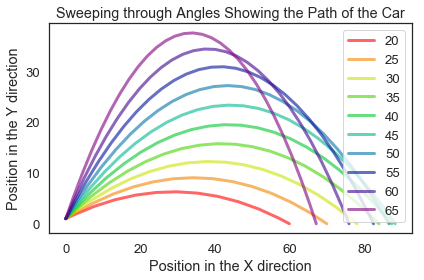

In [67]:
decorate(xlabel='Position in the X direction',
         ylabel='Position in the Y direction')

angle_array = linrange(20, 70, 5)
sweep_angle(params, angle_array)

<h2 align="center"> Sweeping through angles of the bridge from 20 degrees to 65 degrees, showing the path of the sedan in the x and y directions </h2>

<h3 align="center"> This graph above assumes the car is moving at 30 m/s </h3>

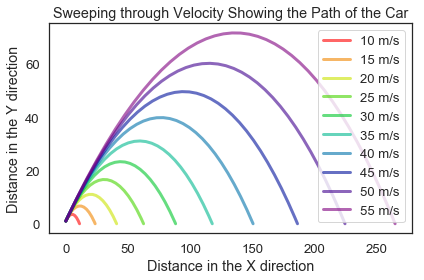

In [68]:
decorate(xlabel='Distance in the X direction',
         ylabel='Distance in the Y direction')

vel_array = linrange(10, 58, 5)
sweep_velocity(params, vel_array)

<h2 align="center"> Sweeping through velocities from 10 m/s to 55 m/s, showing the path of the sedan in the x and y directions </h2>

<h3 align="center"> This graph above assumes the bridge is at an angle of 45 degrees </h3>

## London Bridge
### Stats:
- Total length: 224 meters
- Maximum Gap: 208 meters
- Maximum Angle: 86 degrees

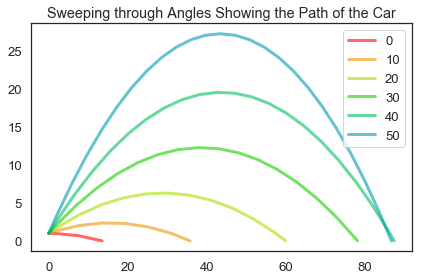

In [69]:
val_array = linrange(0, 90, 10)
red = Color('red')
color_range = list(red.range_to(Color('purple'), len(val_array)))

for (angle, color) in zip(val_array, color_range):
    params = Params(params, angle=angle)
    res = run_ode(params)
    x_dist = res.x
    y_dist = res.y
    if gap_func(angle) < get_last_value(res.x):
        plot (x_dist, y_dist, color=color.rgb, label=str(angle))
    decorate(title = "Sweeping through Angles Showing the Path of the Car")
    

<h2 align="center"> The graph above only displays angles (between 0 and 90 degrees) that the sedan will succeed in making it across. </h2>
<h3 align="center"> Above the graph shows that the car will be successful at it's 30 m/s speed as long as the angle of the bridge is less than 50 degrees in the air.</h3>

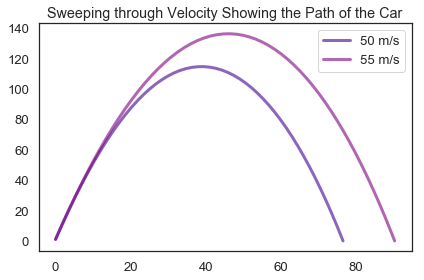

In [70]:
val_array = linrange(10, 58, 5)
red = Color('red')
color_range = list(red.range_to(Color('purple'), len(val_array)))
    
for (velocity, color) in zip(val_array, color_range):
    params = Params(params, velocity=velocity)
    res = run_ode(params)
    x_dist = res.x
    y_dist = res.y
    if gap_func(45) < get_last_value(res.x):
        plot (x_dist, y_dist, color=color.rgb, label=str(velocity) + " m/s")
    decorate(title="Sweeping through Velocity Showing the Path of the Car")

<h2 align="center"> The graph above only displays speeds (between 10 and 58 m/s) that the sedan will succeed in making it across. </h2>
<h3 align="center"> Above the graph shows that the car will be successful (at 45 degrees in the air) as long as the velocity of the car is above 50 m/s.</h3>

# So...? Does the car make it? 

Yes, but only under specific conditions. With the BMW Sedan, you will be able to make it over London Bridge under specific circumstances. Assuming the bridge is at 45 degrees (a default angle) the car would need to be going 50 m/s or faster in order to make it over the gap. Assuming the car is moving at an average of 30 m/s, the bridge would need to be under an angle of 50 degrees. 

We know this because our London Bridge graphs only plot paths of car that will successfully make it over the gap with their limitations listed underneath each. This way, it’s very clear which runs are good data points.


## Volkswagen Beetle

In [71]:
params = Params(x = 0 * m, 
                y = 1 * m,
                l = 3.822 * m, # to change
                w = 1.81 * m, # to change
                h = 1.43 * m, # to change
                g = 9.8 * m/s**2, 
                mass = 1403 * kg, # to change
                rho = 1.2 * kg/m**3,
                C_d = 0.48, # to change
                angle = 45 * degree,
                velocity = 26 * m / s, # to change
                t_end = 1000 * s)

,values
x,0 meter
y,1 meter
l,3.822 meter
w,1.81 meter
h,1.43 meter
g,9.8 meter / second ** 2
mass,1403 kilogram
rho,1.2 kilogram / meter ** 3
C_d,0.48
angle,45 degree


In [72]:
system = make_system(params);

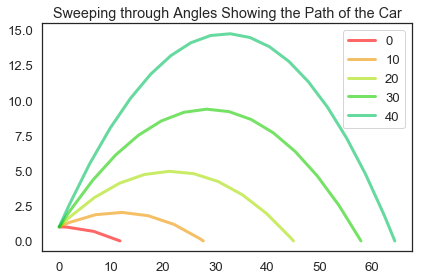

In [73]:
val_array = linrange(0, 90, 10)
red = Color('red')
color_range = list(red.range_to(Color('purple'), len(val_array)))

for (angle, color) in zip(val_array, color_range):
    params = Params(params, angle=angle)
    res = run_ode(params)
    x_dist = res.x
    y_dist = res.y
    if gap_func(angle) < get_last_value(res.x):
        plot (x_dist, y_dist, color=color.rgb, label=str(angle))
    decorate(title = "Sweeping through Angles Showing the Path of the Car")

<h2 align="center"> The graph above only displays angles (between 0 and 90 degrees) that the beetle will succeed in making it across. </h2>
<h3 align="center"> Above the graph shows that the car will be successful at 26 m/s speed as long as the angle of the bridge is less than 40 degrees in the air.</h3>

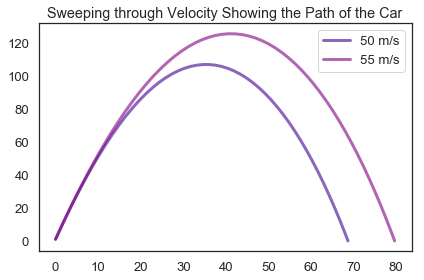

In [74]:
val_array = linrange(10, 58, 5)
red = Color('red')
color_range = list(red.range_to(Color('purple'), len(val_array)))
    
for (velocity, color) in zip(val_array, color_range):
    params = Params(params, velocity=velocity)
    res = run_ode(params)
    x_dist = res.x
    y_dist = res.y
    if gap_func(45) < get_last_value(res.x):
        plot (x_dist, y_dist, color=color.rgb, label=str(velocity) + " m/s")
    decorate(title="Sweeping through Velocity Showing the Path of the Car")

<h2 align="center"> The graph above only displays speeds (between 10 and 58 m/s) that the beetle will succeed in making it across. </h2>
<h3 align="center"> Above the graph shows that the car will be successful (at 45 degrees in the air) as long as the velocity of the car is above 50 m/s.</h3>

## Ferrari F430

In [75]:
params = Params(x = 0 * m, 
                y = 1 * m,
                l = 3.43 * m, # to change
                w = 1.81 * m, # to change
                h = 1.43 * m, # to change
                g = 9.8 * m/s**2, 
                mass = 1528.6 * kg, # to change
                rho = 1.2 * kg/m**3,
                C_d = 0.34, # to change
                angle = 45 * degree,
                velocity = 35 * m / s, # to change
                t_end = 1000 * s)

,values
x,0 meter
y,1 meter
l,3.43 meter
w,1.81 meter
h,1.43 meter
g,9.8 meter / second ** 2
mass,1528.6 kilogram
rho,1.2 kilogram / meter ** 3
C_d,0.34
angle,45 degree


In [76]:
system = make_system(params);

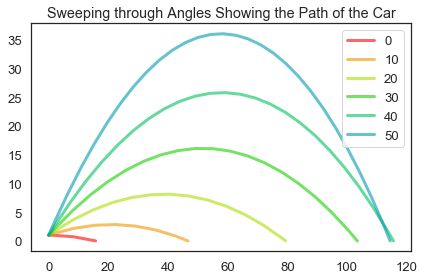

In [77]:
val_array = linrange(0, 90, 10)
red = Color('red')
color_range = list(red.range_to(Color('purple'), len(val_array)))

for (angle, color) in zip(val_array, color_range):
    params = Params(params, angle=angle)
    res = run_ode(params)
    x_dist = res.x
    y_dist = res.y
    if gap_func(angle) < get_last_value(res.x):
        plot (x_dist, y_dist, color=color.rgb, label=str(angle))
    decorate(title = "Sweeping through Angles Showing the Path of the Car")

<h2 align="center"> The graph above only displays angles (between 0 and 90 degrees) that the ferrari will succeed in making it across. </h2>
<h3 align="center"> Above the graph shows that the car will be successful at 35 m/s speed as long as the angle of the bridge is less than 50 degrees in the air.</h3>

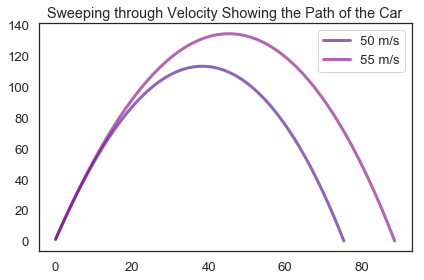

In [78]:
val_array = linrange(10, 58, 5)
red = Color('red')
color_range = list(red.range_to(Color('purple'), len(val_array)))
    
for (velocity, color) in zip(val_array, color_range):
    params = Params(params, velocity=velocity)
    res = run_ode(params)
    x_dist = res.x
    y_dist = res.y
    if gap_func(45) < get_last_value(res.x):
        plot (x_dist, y_dist, color=color.rgb, label=str(velocity) + " m/s")
    decorate(title="Sweeping through Velocity Showing the Path of the Car")

<h2 align="center"> The graph above only displays speeds (between 10 and 58 m/s) that the ferrari will succeed in making it across. </h2>
<h3 align="center"> Above the graph shows that the car will be successful (at 45 degrees in the air) as long as the velocity of the car is above 50 m/s.</h3>

# Interpretation

One of our main limitations in this model is assuming the bridge is stationary during takeoff and landing. Many times in the movie scenes we are modeling after, cars jump off one side as the bridge is in the process of moving or lowering, meaning we would have different angles and gap sizes as time moved forward. Our code also doesn’t consider the combined effect of angle and velocity. We only addressed them separately, but in reality they’d work mutually to produce a specific distance. 

Throughout our process, we found lots of little additions that allowed us to have fun with modeling. For one, we researched different types of cars and added comparisons between their performances. For another, we decided to add-on applying our data to an actual drawbridge, so we research and calculated statistics for the London Bridge before applying our model to it. Additionally, we found it was easy to read our sweeps with color coordination, so we added in rainbow colors + keys to add visual appeal. 